In [0]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision
    ! pip install --upgrade git+https://github.com/sovrasov/flops-counter.pytorch.git

try:
    import torchtext
except:
    !pip install torchtext
    
try:
    import spacy
except:
    !pip install spacy
    
try:
    spacy.load('en')
except:
    !python -m spacy download en

# Data loading and preprocessing

In [0]:
import torch
from torchtext import data
import torch.nn.functional as F
from torch import nn
from torch import optim
from torch.distributions import Categorical
from torch.distributions import Binomial
from torchtext import datasets
import os.path

import random
import numpy as np

In [3]:
TEXT = data.Field(tokenize='spacy', lower=True, include_lengths=True)
LABEL = data.LabelField(dtype=torch.float)
_train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

aclImdb_v1.tar.gz:   0%|          | 164k/84.1M [00:00<00:57, 1.47MB/s]

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:14<00:00, 5.93MB/s]


In [4]:
train_data, valid_data = _train_data.split(0.8)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 20000
Number of validation examples: 5000
Number of testing examples: 25000


In [5]:
TEXT.build_vocab(train_data, max_size=100000, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

.vector_cache/glove.6B.zip: 862MB [03:29, 4.12MB/s]                           
100%|█████████▉| 398204/400000 [00:19<00:00, 20314.70it/s]

Unique tokens in TEXT vocabulary: 91156
Unique tokens in LABEL vocabulary: 2


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cpu


# Model and training

In [0]:
BATCH_SIZE = 50

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device,
    shuffle = False,
    sort_key=lambda x: len(x.text),
    sort_within_batch=True)

In [0]:
eps = torch.tensor(1e-9)
temp = []
R = 20 # chunk of words read or skipped

def reward_function(prob, true_label):
    """
    Returns 1 if correct prediction, -1 otherwise
    """
    # print("true_label", "prob", true_label, prob)
    if prob>0.5 and true_label>0.5:
        return torch.tensor(1.0, requires_grad=True)
    if prob<0.5 and true_label<0.5:
        return torch.tensor(1.0, requires_grad=True)
    return torch.tensor(-1.0, requires_grad=True)

def sample_binary(prob):
    if prob>random.random:
        return torch.tensor(1)
    return torch.tensor(0)

class SkipReadingModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, gamma=0.99, train_mode=True, K=4):
        super().__init__()
        
        # store dimensions and constants
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.gamma = torch.tensor(gamma)
        self.train_mode = train_mode
        self.K = K
        
        # create layers
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.lstm_cell = nn.LSTMCell(input_size = embedding_dim, hidden_size = hidden_dim, bias = True)
        self.stop_linear_1 = nn.Linear(hidden_dim, hidden_dim)
        self.stop_linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.stop_linear_3 = nn.Linear(hidden_dim, 1)
        
        self.jumping_linear_1 = nn.Linear(hidden_dim, hidden_dim)
        self.jumping_linear_2 = nn.Linear(hidden_dim, hidden_dim)
        self.jumping_linear_3 = nn.Linear(hidden_dim, K)
        
        self.output_linear_1 = nn.Linear(hidden_dim, hidden_dim)
        self.output_linear_2 = nn.Linear(hidden_dim, output_dim)
        
        self.value_head = nn.Linear(hidden_dim, 1)
        
        # Baseline weight        
        self.wb = nn.Parameter(data=torch.zeros(self.hidden_dim), requires_grad=True)
        self.cb = nn.Parameter(data=torch.tensor((0.0)), requires_grad=True)
        
        # Initialize lstm_cell states
        self.initialize_lstm_cell_states()
        
        # Initalize episode number and time number
        self.initialize_for_new_batch()
        self.initialize_time_number()
        
        # Overall reward and loss history
        self.reward_history = []
        self.loss_history = []
        self.training_accuracies = []
        self.validation_accuracies = []
        # torch.tensor((0.0), requires_grad=True) 
    
    def initialize_lstm_cell_states(self):
        self.c = torch.zeros(1, self.hidden_dim, requires_grad=True)
        self.h = torch.zeros(1, self.hidden_dim, requires_grad=True)
            
    def initialize_episode_number(self):
        self.ep = 0
    
    def initialize_time_number(self):
        self.t = 0
    
    def clear_batch_lists(self):
        del self.saved_log_probs_s[:]
        del self.saved_log_probs_n[:]
        del self.saved_log_probs_o[:]
        del self.reward_baselines[:]
        del self.rewards[:]
        del self.label_targets[:]
        del self.label_predictions[:]
        del self.state_values[:]
        self.initialize_episode_number()
        self.training_accuracy = 0.0
    
    def initialize_for_new_batch(self):
        """
        Cleans history of log probabilities, rewards, targets etc for the last
        batch
        """
        self.initialize_episode_number()
        
        # Episode policy and reward history 
        self.saved_log_probs_s = [] # log probabilities for each time step t in each episode in batch
        self.saved_log_probs_n = [] # log probs for jump
        self.saved_log_probs_o = [] # log_prob for class
        self.rewards = [] # reward at final time step of each episode in batch
        self.reward_baselines = [] # reward baselines for each time step t in each episode in batch
        self.state_values = []

        # Predictions and targets history (for cross entropy loss calculation)
        self.label_predictions = [] # 1 probability for each episode
        self.label_targets = []# 1 label for each episode
        self.training_accuracy = 0.0

        
    def classify(self):
        # global temp
        # temp.append(self.c[0])
        out = self.output_linear_1(self.c[0])
        out = self.output_linear_2(out)
        self.label_predictions.append(out)
        prob_o = torch.sigmoid(out)
        class_categ = Binomial(probs=prob_o)
        _class = class_categ.sample()
        if self.train_mode:
            self.rewards.append(reward_function(_class, self.label_targets[-1]))
            self.saved_log_probs_o.append((class_categ.log_prob(_class), ))
        # return torch.sigmoid(out)
       
    def get_baseline(self):
        return torch.dot(self.wb, self.c[0].detach()) + self.cb
    
    def save_training_accuracy(self):
        correct = 0
        for _r in self.rewards:
            if _r > 0:
                correct += 1
        self.training_accuracy = correct/len(self.rewards)
        self.training_accuracies.append(self.training_accuracy)
      
    
    def forward(self, pack):
        texts, lengths, labels = pack
        embeddeds = self.embedding(texts)
        # embeddeds = nn.utils.rnn.pack_padded_sequence(embeddeds, lengths)
        self.initialize_for_new_batch()

        for episode_number in range(embeddeds.shape[1]):
            
            # load episode data
            self.ep = episode_number
            embedded = embeddeds[:, self.ep, :]
      
            #print(texts.shape, embeddeds.shape, embedded.shape)
            #print(label)
            
            # initialize counters and index
            tokens_read = 0
            jumps_made = 0
            word_index = 0
            words_len = embedded.shape[0]
            self.initialize_lstm_cell_states()
            self.initialize_time_number()
            self.saved_log_probs_s.append([])
            self.saved_log_probs_n.append([])
            self.state_values.append([])
            self.reward_baselines.append([])            
            if self.train_mode:
                label = labels[self.ep].reshape(1)
                self.label_targets.append(label)

            # start iterating through sequence, while skipping some words
            while word_index<words_len and word_index<400:
                self.t += 1                
                #print("embedded_word", embedded_word.shape)

                # generate next lstm cell state
                for _r in range(min(R, words_len-word_index)):
                    embedded_word = embedded[word_index]
                    self.h, self.c = self.lstm_cell(torch.reshape(embedded_word, (1, -1)), (self.h, self.c))
                    word_index += 1
                # print('word_index', word_index, 'tokens_read', tokens_read, 'jumps_made', jumps_made)
                
                # print(self.c)
                _state_value = self.value_head(self.c[0])
                self.state_values.append(_state_value)
                
                _s = self.stop_linear_1(self.c[0])
                _s = F.relu(_s)
                _s = self.stop_linear_2(_s)
                _s = F.relu(_s)
                _s = self.stop_linear_3(_s)

                probs_s = torch.sigmoid(_s)
                try:
                    stop_categ = Binomial(probs=probs_s)
                    stop = stop_categ.sample()
                except:
                    print("_c", self.c)
                    #temp = (self.c, _s, probs_s, self.stop_linear_1, self.stop_linear_2, self.stop_linear_3, stop_categ)
                    raise ValueError('got the expected error')
              # Add log probability of our chosen action to our history
                self.saved_log_probs_s[-1].append(stop_categ.log_prob(stop))
                self.reward_baselines[-1].append(self.get_baseline())

                if stop > 0.5:
                    self.classify()
                    break
                else:
                    _n = self.jumping_linear_1(self.c[0])
                    _n = F.relu(_n)
                    _n = self.jumping_linear_2(_n)
                    _n = F.relu(_n)
                    _n = self.jumping_linear_3(_n)
                    _n = F.softmax(_n)
                    n_categ = Categorical(_n)
                    n = n_categ.sample()
                    self.saved_log_probs_n[-1].append(n_categ.log_prob(n))
                    word_index += n * R
            else:
                # print("Finished while loop")
                # raise ValueError('Finshed ')
                self.classify()
        if self.train_mode:
            self.save_training_accuracy()
        return self.label_predictions 
      

In [0]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = 1
FLOP_COST = 0.0001

seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

bce = nn.BCEWithLogitsLoss(reduction='mean')
policy_model = SkipReadingModel(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
pretrained_embeddings = TEXT.vocab.vectors
policy_model.embedding.weight.data.copy_(pretrained_embeddings)

if os.path.exists('fast_text_model.weights'):
    policy_model.load_state_dict(torch.load('fast_text_model.weights'))

# define the optimiser
optimizer = optim.Adam(policy_model.parameters(), lr=0.01)

In [0]:
def update_policy():
   
    #print(len(policy_model.rewards), len(policy_model.label_predictions), len(policy_model.label_targets))
    #print(len(policy_model.saved_log_probs_o), len(policy_model.saved_log_probs_n), len(policy_model.saved_log_probs_s))
    #print(len(policy_model.reward_baselines))
    
    policy_loss_sum = torch.tensor(0.0, requires_grad=True)
    reward_sum = torch.tensor(0.0, requires_grad=True)
    baseline_loss_sum = torch.tensor(0.0, requires_grad=True)
    value_loss_sum = torch.tensor(0.0, requires_grad=True)
    
    for reward, prediction, target, log_probs_o, log_probs_n, log_probs_s, baselines, svs in zip(
        policy_model.rewards, policy_model.label_predictions,
        policy_model.label_targets, policy_model.saved_log_probs_o,
        policy_model.saved_log_probs_n, policy_model.saved_log_probs_s,
        policy_model.reward_baselines, policy_model.state_values):
      
            for lpn in log_probs_n:
                policy_loss_sum = policy_loss_sum + lpn
          
            for i, (lps, b, sv) in enumerate(zip(log_probs_s, baselines, svs)):
                policy_loss_sum = policy_loss_sum + lps
                r = torch.pow(policy_model.gamma, i) * (-FLOP_COST)
                if i == len(svs)-1:
                    r = r + torch.pow(policy_model.gamma, i) * reward
                adv = r - sv.item()
                reward_sum = reward_sum + adv
                value_loss_sum = value_loss_sum + F.smooth_l1_loss(sv, torch.tensor([r]))
                # baseline_loss_sum = baseline_loss_sum + torch.pow(rew, 2)

            # baseline_loss_sum = baseline_loss_sum - torch.pow(rew, 2) + torch.pow(torch.pow(policy_model.gamma, i) * reward + rew, 2)
            policy_loss_sum = policy_loss_sum + log_probs_o[0]
    
    # print("reward sum", reward_sum)
    # print("policy_loss_sum", policy_loss_sum)
    
    loss = policy_loss_sum * reward_sum + value_loss_sum
    
    optimizer.zero_grad()
    # print('policy_loss', policy_loss)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    policy_model.clear_batch_lists()

In [0]:
def test_model():
    policy_model.train_mode = True
    correct = 0
    total=0
    for _data in test_iterator:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
        predictions = policy_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        for (prediction, label) in zip(predictions, labels):
            if reward_function(label, prediction) > 0:
                correct += 1
            total += 1
        if total%1000 == 0:
            print(total)
        if total%5000 == 0:
            break
    print("Test accuracy :", correct/total)
    policy_model.train_mode = True
    return correct/total

def validate_model():
    policy_model.train_mode = True
    correct = 0
    total=0
    for _data in valid_iterator:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
        predictions = policy_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        for (prediction, label) in zip(predictions, labels):
            if reward_function(label, prediction) > 0:
                correct += 1
            total += 1
        if total%1000 == 0:
            break
    print("Validation accuracy :", correct/total)
    policy_model.train_mode = True
    policy_model.validation_accuracies.append(correct/total)
    return correct/total

# test_model()

In [20]:
# the epoch loop

with torch.enable_grad():
    validate_model()
    for epoch in range(10):
        running_reward = 10
        t = 0
        for _data in train_iterator:
            # get the inputs
            texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
            # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
            prediction = policy_model((texts.to(device), text_lengths.to(device), labels.to(device)))
            # print("Prediction", prediction.item())        
            # raise ValueError('Not done')
            t += 1
            if t%2 == 0:
                print("batch no. %d, training accuracy %4.2f" % (t, policy_model.training_accuracy))
            if t%10 == 0:
                validate_model()
                #print("wb", policy_model.wb)
                # print("lstm hh hi", policy_model.lstm_cell.weight_hh[0][::10], policy_model.lstm_cell.weight_ih[0][::10])
                #print("lstm hh hi", policy_model.lstm_cell.weight_hh, policy_model.lstm_cell.weight_ih)
                #print("emb", policy_model.embedding.weight)
                #print("jmp", policy_model.jumping_linear.weight)
                #print("out", policy_model.output_linear.weight)
            if t%1000 == 0:
                break
            update_policy()
        #running_reward = 0.05 * policy_model.reward_episode + (1 - 0.05) * running_reward
        #print("Epoch %d, reward %4.2f" % (epoch, running_reward))
        print("Epoch %d" % (epoch))
    print('**** Finished Training ****')
# test_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:210: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Validation accuracy : 0.424


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


batch no. 2, training accuracy 0.54
batch no. 4, training accuracy 0.52
batch no. 6, training accuracy 0.52
batch no. 8, training accuracy 0.44
batch no. 10, training accuracy 0.56
Validation accuracy : 0.576
batch no. 12, training accuracy 0.48
batch no. 14, training accuracy 0.66
batch no. 16, training accuracy 0.58
batch no. 18, training accuracy 0.46
batch no. 20, training accuracy 0.46
Validation accuracy : 0.576
batch no. 22, training accuracy 0.46
batch no. 24, training accuracy 0.46
batch no. 26, training accuracy 0.46
batch no. 28, training accuracy 0.44
batch no. 30, training accuracy 0.44
Validation accuracy : 0.576
batch no. 32, training accuracy 0.42
batch no. 34, training accuracy 0.54
batch no. 36, training accuracy 0.56
batch no. 38, training accuracy 0.52
batch no. 40, training accuracy 0.42
Validation accuracy : 0.576
batch no. 42, training accuracy 0.62
batch no. 44, training accuracy 0.48
batch no. 46, training accuracy 0.42
batch no. 48, training accuracy 0.46
batc

KeyboardInterrupt: ignored

In [0]:
torch.save(policy_model.state_dict(), 'fast_text_model.weights')

# Evaluation

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:210: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


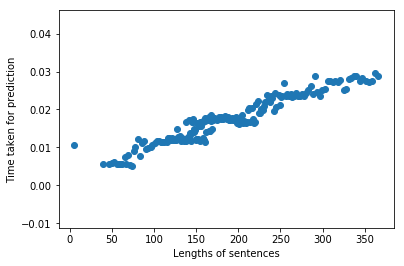

In [23]:
import timeit
import spacy
import matplotlib.pyplot as plt
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    model.train_mode = False
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    # tensor = torch.LongTensor(indexed).to(device)
    tensor = torch.LongTensor(indexed).to('cpu')
    tensor = tensor.unsqueeze(1)
    model((tensor, torch.tensor([tensor.shape[0]]), None))
    res = torch.sigmoid(model.label_predictions[0])
    model.train_mode = False
    return res

times = []
lengths=[]
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=1,
    device=device,
    shuffle = True,
    # sort_key=lambda x: len(x.text),
    sort_within_batch=False)

i = 0
for _data in test_iterator:
    if i%100 == 0:
        # get the inputs
        texts, text_lengths, labels = _data.text[0], _data.text[1], _data.label
        #print(texts.shape, text_lengths.shape, labels.shape)
        start_time = timeit.default_timer()
        predictions = policy_model((texts.to(device), text_lengths.to(device), labels.to(device)))
        elapsed = timeit.default_timer() - start_time
        lengths.append(texts.shape[0])
        times.append(elapsed)
        # print("Input review texts, text_lengths, labels", texts.shape, text_lengths.shape, labels.shape)
    if i>20000:
        break
    i += 1

import pickle

pickle_out = open("test_times_1.pickle","wb")
pickle.dump((lengths, times), pickle_out)
pickle_out.close()

plt.scatter(lengths, times, label='skip-model')
plt.xlabel('Lengths of sentences')
plt.ylabel('Time taken for prediction')
plt.show()

In [0]:
predict_sentiment(policy_model, "This film is terrible what can I say")

In [0]:
import pickle

pickle_out = open("training_epochs_1.pickle","wb")
pickle.dump((policy_model.training_accuracies, policy_model.validation_accuracies), pickle_out)
pickle_out.close()